# Centralised Learning and Federated Learning on the CICIoT2023 dataset

This notebook extends on the functionality of the CICIoT2023 example notebook, to account for improvement to the centralised training of all data instances.

In [30]:
import pandas as pd
import numpy as np
import os
import pickle
from tqdm import tqdm
import warnings
#warnings.filterwarnings('ignore')


In [31]:
DATASET_DIRECTORY = '/kaggle/input/creating-a-smaller-dataset-for-ciciot2023/'

Include the defines for the dataframe columns and the attack labels and their mappings

In [32]:
# from includes import X_columns, y_column, dict_34_classes, dict_8_classes, dict_7_classes, dict_2_classes

"""
This module defines the global variables and dictionaries used in the project.

It contains definitions for columns used in the dataset, mapping functions for 
the attack labels, and several dictionaries of attack types for varying classes 
of traffic.

The dictionaries of attack types include:
- 34 classes, which includes 33 attack classes and one for benign traffic
- 8 classes, which includes separate classes for DDoS and DoS attacks
- 7 classes, which groups DDoS and DoS attacks into a single class
- 2 classes, which classifies traffic as either benign or malicious
"""

from enum import Enum

# Define the colours used for text printing
class Colours(Enum):
    RED = "\033[31m"
    GREEN = "\033[32m"
    YELLOW = "\033[33m"
    BLUE = "\033[34m"
    MAGENTA = "\033[35m"
    CYAN = "\033[36m"
    WHITE = "\033[37m"
    BOLD = "\033[1m"
    NORMAL = "\033[0m"

X_columns = [
    'flow_duration', 'header_length', 'protocol_type', 'duration',
    'rate', 'srate', 'drate', 'fin_flag_number', 'syn_flag_number',
    'rst_flag_number', 'psh_flag_number', 'ack_flag_number',
    'ece_flag_number', 'cwr_flag_number', 'ack_count',
    'syn_count', 'fin_count', 'urg_count', 'rst_count', 
    'http', 'https', 'dns', 'telnet', 'smtp', 'ssh', 'irc', 'tcp',
    'udp', 'dhcp', 'arp', 'icmp', 'ipv', 'llc', 'tot_sum', 'min',
    'max', 'avg', 'std', 'tot_size', 'iat', 'number', 'magnitude',
    'radius', 'covariance', 'variance', 'weight'
]

y_column = 'label'

dict_34_classes = {'BenignTraffic': 0,
                    'DDoS-RSTFINFlood' :1, 'DDoS-PSHACK_Flood':2,  'DDoS-SYN_Flood':3, 'DDoS-UDP_Flood':4, 'DDoS-TCP_Flood':5, 
                    'DDoS-ICMP_Flood':6, 'DDoS-SynonymousIP_Flood':7, 'DDoS-ACK_Fragmentation':8, 'DDoS-UDP_Fragmentation':9, 'DDoS-ICMP_Fragmentation':10, 
                    'DDoS-SlowLoris':11, 'DDoS-HTTP_Flood':12, 'DoS-UDP_Flood':13, 'DoS-SYN_Flood':14, 'DoS-TCP_Flood':15, 'DoS-HTTP_Flood':16,
                    'Mirai-greeth_flood': 17, 'Mirai-greip_flood': 18, 'Mirai-udpplain': 19,
                    'Recon-PingSweep': 20, 'Recon-OSScan': 21, 'Recon-PortScan': 22, 'VulnerabilityScan': 23, 'Recon-HostDiscovery': 24,
                    'DNS_Spoofing': 25, 'MITM-ArpSpoofing': 26,
                    'BrowserHijacking': 27, 'Backdoor_Malware': 28, 'XSS': 29, 'Uploading_Attack': 30, 'SqlInjection': 31, 'CommandInjection': 32,
                    'DictionaryBruteForce': 33}

# Some parts of the paper talk about 8 classes and split DDoS and DoS into seperate classes
dict_8_classes = {  0: 0 ,                                                                                                                                      # Benign
                    1:1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1, 8: 1, 9: 1, 10: 1, 11: 1, 12: 1,                                                                   # DDoS
                    13: 7, 14: 7, 15: 7, 16: 7,                                                                                                                 # DoS                    
                    17: 2, 18: 2, 19: 2,                                                                                                                        # Mirai
                    20: 3, 21: 3, 22: 3, 23: 3, 24: 3,                                                                                                          # Reconnaissance
                    25: 4, 26: 4,                                                                                                                               # Spoofing
                    27: 5, 28: 5, 29: 5, 30: 5, 31: 5, 32: 5,                                                                                                   # Web
                    33: 6}                                                                                                                                      # Brute Force

# Example Notebook provides a "dict_7classes" list that is infact 8 classes. This shouldnt be used as far as I can tell                  
dict_7_classes = {  0: 0 ,                                                                                                                                      # Benign
                    1 :1, 2:1,  3:1, 4:1, 5:1, 6:1, 7:1, 8:1, 9:1, 10:1, 11:1, 12:1, 13:1, 14:1, 15:1, 16:1,                                                    # DDoS and DoS                    
                    17: 2, 18: 2, 19: 2,                                                                                                                        # Mirai
                    20: 3, 21: 3, 22: 3, 23: 3, 24: 3,                                                                                                          # Reconnaissance
                    25: 4, 26: 4,                                                                                                                               # Spoofing
                    27: 5, 28: 5, 29: 5, 30: 5, 31: 5, 32: 5,                                                                                                   # Web
                    33: 6}                                                                                                                                      # Brute Force

# Binary classes
dict_2_classes = {  0: 0 ,                                                                                                                                      # Benign
                    1 :1, 2:1,  3:1, 4:1, 5:1, 6:1, 7:1, 8:1, 9:1, 10:1, 11:1, 12:1, 13:1, 14:1, 15:1, 16:1,                                                    # DDoS and DoS  
                    17: 1, 18: 1, 19: 1,                                                                                                                        # Mirai 
                    20: 1, 21: 1, 22: 1, 23: 1, 24: 1,                                                                                                          # Reconnaissance
                    25: 1, 26: 1,                                                                                                                               # Spoofing
                    27: 1, 28: 1, 29: 1, 30: 1, 31: 1, 32: 1,                                                                                                   # Web
                    33: 1}                                                                                                                                      # Brute Force

In [33]:
df_sets = [k for k in os.listdir(DATASET_DIRECTORY) if k.endswith('.csv')]
df_sets.sort()

# # Create the training and test sets
training_sets = df_sets[:int(len(df_sets)*.8)]
test_sets = df_sets[int(len(df_sets)*.8):]

# TODO - REMOVE THIS - Works on 20% of the data for low memory machines
# Create the training and test sets - LOW MEMORY CLUDGE FOR JON
# training_sets = df_sets[:int(len(df_sets)*.2)]
# test_sets = df_sets[int(len(df_sets)*.8):]

---
# TEMP CODE

In [34]:
# Set training_sets to the last entry of training_sets
training_sets = training_sets[-1:]
print(f"HACK TO REPLICATE ORIGINAL AUTHORS CODE WITH ONE FILE TRAIN - {training_sets}")

HACK TO REPLICATE ORIGINAL AUTHORS CODE WITH ONE FILE TRAIN - ['0.05percent_8classes.csv']


Remove this if you have more than a morsel of memory

---

# Create a new DataFrame that consists of all CSV datA

This is **memory intensive** as it will create a DataFrame with 36 million rows.

In [35]:

df = []

count = 0
for train_set in tqdm(training_sets):
    if count == 0:
        df = pd.read_csv(DATASET_DIRECTORY + train_set)
    else:
        df_new = pd.read_csv(DATASET_DIRECTORY + train_set)
        df = df.append(df_new, ignore_index=True)
    count = count + 1

100%|██████████| 1/1 [00:14<00:00, 14.12s/it]


In [36]:
# # New faster method not using depreciated pandas append
# dfs = []
# for train_set in tqdm(training_sets):
#     df_new = pd.read_csv(DATASET_DIRECTORY + train_set)
#     dfs.append(df_new)
# df = pd.concat(dfs, ignore_index=True)# FIX: Map string labels to categorical classes



# FIX: Map string labels to categorical classes
print("Mapping string labels to categories...")
print(f"Unique string labels: {sorted(df['label'].unique())}")

# Check if these match any of our dictionaries
print("Checking label mapping...")

# Since you have 8 unique labels and want binary classification, 
# let's see what the actual labels are and map them appropriately
unique_labels = sorted(df['label'].unique())
print(f"The 8 unique labels are: {unique_labels}")

# Create a simple mapping - assuming 'Benign' = 0, everything else = 1 for binary
# You can adjust this mapping based on what the actual labels are
if 'Benign' in unique_labels or 'BenignTraffic' in unique_labels:
    # Binary mapping: Benign = 0, all attacks = 1
    df['label'] = df['label'].apply(lambda x: 0 if 'Benign' in str(x) else 1)
else:
    # If no 'Benign' found, map alphabetically to 0-7
    label_to_num = {label: i for i, label in enumerate(unique_labels)}
    print(f"Label mapping: {label_to_num}")
    df['label'] = df['label'].map(label_to_num)

print(f"After mapping - Unique labels: {sorted(df['label'].unique())}")
print(f"Label distribution:\n{df['label'].value_counts().sort_index()}")

# Preserve original labels  
df['original_label'] = df['label']
df['label_34'] = df['label']

print("Label processing completed successfully!")

Mapping string labels to categories...
Unique string labels: ['Benign', 'BruteForce', 'DDoS', 'DoS', 'Mirai', 'Recon', 'Spoofing', 'Web']
Checking label mapping...
The 8 unique labels are: ['Benign', 'BruteForce', 'DDoS', 'DoS', 'Mirai', 'Recon', 'Spoofing', 'Web']
After mapping - Unique labels: [0, 1]
Label distribution:
label
0      54908
1    2279392
Name: count, dtype: int64
Label processing completed successfully!


In [37]:
df

,flow_duration,header_length,protocol_type,duration,rate,srate,drate,fin_flag_number,syn_flag_number,rst_flag_number,...,iat,number,radius,covariance,variance,weight,label,magnitude,original_label,label_34
0,0.000000,1,ICMP,63.89,26,26,0.0,False,False,False,...,8.312472e+07,9.5,4.566187,87.988464,0.12,141.55,1,9.260885,1,1
1,0.022700,19157,CHAOS,63.85,16944,16944,0.0,False,False,False,...,8.303328e+07,9.5,0.476009,1.891419,0.06,141.55,1,10.008313,1,1
2,0.059647,27289,UDP,64.00,16216,16216,0.0,False,False,False,...,8.312362e+07,9.5,0.000000,0.000000,0.00,141.55,1,10.000000,1,1
3,0.010380,6312,CHAOS,71.64,12182,12182,0.0,False,False,False,...,8.310223e+07,9.5,0.846762,3.620116,0.10,141.55,1,10.020020,1,1
4,0.024707,11925,UDP,64.00,8967,8967,0.0,False,False,False,...,8.310693e+07,9.5,0.000000,0.000000,0.00,141.55,1,10.000000,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2334295,0.000000,54,TCP,64.00,6,6,0.0,False,False,False,...,8.331387e+07,9.5,0.000000,0.000000,0.00,141.55,1,10.392304,1,1
2334296,6.221767,4677541,TCP,56.50,682,682,0.0,False,False,False,...,2.316952e-04,5.5,1147.053800,777046.900000,0.90,38.50,1,67.472320,1,1
2334297,0.000000,54,TCP,64.00,0,0,0.0,True,False,True,...,8.334506e+07,9.5,0.000000,0.000000,0.00,141.55,1,10.392304,1,1
2334298,0.000000,54,TCP,64.00,20,20,0.0,False,True,False,...,8.298162e+07,9.5,0.000000,0.000000,0.00,141.55,1,10.392304,1,1


In [38]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2334300 entries, 0 to 2334299
Data columns (total 49 columns):
 #   Column           Dtype  
---  ------           -----  
 0   flow_duration    float64
 1   header_length    int64  
 2   protocol_type    object 
 3   duration         float64
 4   rate             int64  
 5   srate            int64  
 6   drate            float64
 7   fin_flag_number  bool   
 8   syn_flag_number  bool   
 9   rst_flag_number  bool   
 10  psh_flag_number  bool   
 11  ack_flag_number  bool   
 12  ece_flag_number  bool   
 13  cwr_flag_number  bool   
 14  ack_count        float64
 15  syn_count        float64
 16  fin_count        int64  
 17  urg_count        int64  
 18  rst_count        int64  
 19  http             bool   
 20  https            bool   
 21  dns              bool   
 22  telnet           bool   
 23  smtp             bool   
 24  ssh              bool   
 25  irc              bool   
 26  tcp              bool   
 27  udp         

In [39]:
df.describe()

,flow_duration,header_length,duration,rate,srate,drate,ack_count,syn_count,fin_count,urg_count,...,iat,number,radius,covariance,variance,weight,label,magnitude,original_label,label_34
count,2.334300e+06,2.334300e+06,2.334300e+06,2.334300e+06,2.334300e+06,2.334300e+06,2.334300e+06,2.334300e+06,2.334300e+06,2.334300e+06,...,2.334300e+06,2.334300e+06,2.334300e+06,2.334300e+06,2.334300e+06,2.334300e+06,2.334300e+06,2.334300e+06,2.334300e+06,2.334300e+06
mean,5.593242e+00,7.663165e+04,6.633568e+01,9.123290e+03,9.123290e+03,2.545727e-06,9.055317e-02,3.303418e-01,7.407488e-02,6.168786e+00,...,8.317460e+07,9.498127e+00,4.711282e+01,3.086002e+04,9.641798e-02,1.415030e+02,9.764777e-01,1.312244e+01,9.764777e-01,9.764777e-01
std,2.627411e+02,4.609125e+05,1.393445e+01,9.963112e+04,9.963112e+04,7.474065e-04,2.865076e-01,6.633365e-01,2.925268e-01,7.119865e+01,...,1.704676e+07,8.190186e-01,2.270015e+02,3.340948e+05,2.329740e-01,2.106680e+01,1.515552e-01,8.629887e+00,1.515552e-01,1.515552e-01
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,9.165152e+00,0.000000e+00,0.000000e+00
25%,0.000000e+00,5.400000e+01,6.400000e+01,2.000000e+00,2.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,8.307157e+07,9.500000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.415500e+02,1.000000e+00,1.000000e+01,1.000000e+00,1.000000e+00
50%,0.000000e+00,5.400000e+01,6.400000e+01,1.500000e+01,1.500000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,8.312452e+07,9.500000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.415500e+02,1.000000e+00,1.039230e+01,1.000000e+00,1.000000e+00
75%,1.052728e-01,2.800000e+02,6.400000e+01,1.170000e+02,1.170000e+02,0.000000e+00,0.000000e+00,6.000000e-02,0.000000e+00,0.000000e+00,...,8.334390e+07,9.500000e+00,5.059213e-01,1.344216e+00,8.000000e-02,1.415500e+02,1.000000e+00,1.039672e+01,1.000000e+00,1.000000e+00
max,7.463142e+04,9.865998e+06,2.550000e+02,8.388608e+06,8.388608e+06,6.060958e-01,5.600000e+00,1.263000e+01,8.000000e+01,4.164000e+03,...,1.676394e+08,1.500000e+01,1.546038e+04,1.435427e+08,1.000000e+00,2.446000e+02,1.000000e+00,1.434332e+02,1.000000e+00,1.000000e+00


## Map the y labels to integers

In [40]:
# # Map y column to the dict_34_classes values
# df['label'] = df['label'].map(dict_34_classes)
# Preserve original labels before any mapping
df['original_label'] = df['label']

# Map to 34-class numeric labels
df['label_34'] = df['original_label'].map(dict_34_classes)

# By default, use label_34
df['label'] = df['label_34']


# Save this output to a Pickle file

In [41]:
df.to_pickle('training_data.pkl')

We can now retrieve the dataset from the pkl in further work (pickle file approx 2GB compared to 12GB of CSV data).

---

# Read the pickle file


In [42]:
# Read the pickle file
df = pd.read_pickle('training_data.pkl')

In [101]:
# #################################Debugging################################
# # DIAGNOSTIC: Check what the actual labels are in the dataset
# print("Checking actual labels in the dataset...")
# print(f"Original label column unique values: {df['original_label'].unique()}")
# print(f"Number of unique original labels: {len(df['original_label'].unique())}")
# print(f"Sample of original labels: {df['original_label'].head(10).tolist()}")

# # Check if original labels match dict_34_classes keys
# dict_keys = list(dict_34_classes.keys())
# print(f"Dict_34_classes keys: {dict_keys[:10]}...")  # Show first 10
# print(f"Do original labels match dict keys? {set(df['original_label'].unique()).issubset(set(dict_keys))}")

In [102]:
# ################Debugging###################
# # Check the raw label column from the CSV
# print("Checking raw label column...")
# print(f"Label column name: '{y_column}'")
# print(f"Label column dtype: {df[y_column].dtype}")
# print(f"Label column unique values: {df[y_column].unique()}")
# print(f"Label column null count: {df[y_column].isnull().sum()}")
# print(f"Total rows: {len(df)}")

# # Check if the label column exists and what it contains
# if y_column in df.columns:
#     print(f"Label column exists. Sample values: {df[y_column].head(10).tolist()}")
# else:
#     print(f"ERROR: Label column '{y_column}' does not exist!")
#     print(f"Available columns: {df.columns.tolist()}")

In [103]:
# # RELOAD THE ORIGINAL DATA AND FIX LABELS
# print("Reloading original data...")
# df = pd.read_csv(DATASET_DIRECTORY + training_sets[0])  # Reload the original CSV
# print(f"Original data shape: {df.shape}")
# print(f"Original label column: {df.columns[-1]}")  # Usually the last column
# print(f"Sample of actual labels in CSV: {df.iloc[:, -1].unique()[:10]}")

# # Check what the label column is actually called and what values it contains
# label_col_name = df.columns[-1]  # Assume label is the last column
# print(f"Actual label values: {sorted(df[label_col_name].unique())}")

# # Now map these ACTUAL labels to your dict_34_classes
# # If the labels are already numeric (0-33), just use them directly:
# if df[label_col_name].dtype in ['int64', 'float64']:
#     df['label'] = df[label_col_name]
#     print("Labels were already numeric, using directly")
# else:
#     # If they're strings, map them using dict_34_classes
#     df['label'] = df[label_col_name].map(dict_34_classes)
#     print("Labels mapped using dict_34_classes")

# print(f"Final label distribution: {sorted(df['label'].unique())}")
# print(f"Any NaN labels: {df['label'].isnull().sum()}")

In [104]:
# ######################Debugging##############
# # CHECK FOR THE CORRECT LABEL COLUMN
# print("Checking for correct label column...")
# print(f"All columns in CSV: {df.columns.tolist()}")
# print(f"Looking for column named: '{y_column}'")

# if y_column in df.columns:
#     print(f"Found '{y_column}' column!")
#     print(f"Label column dtype: {df[y_column].dtype}")
#     print(f"Unique labels in '{y_column}': {sorted(df[y_column].unique())}")
#     print(f"Sample labels: {df[y_column].head(10).tolist()}")
    
#     # Check if these are string labels that need mapping
#     if df[y_column].dtype == 'object':
#         print("Labels are strings - need mapping")
#         df['label'] = df[y_column].map(dict_34_classes)
#     else:
#         print("Labels are numeric - using directly")
#         df['label'] = df[y_column]
# else:
#     print(f"ERROR: '{y_column}' column not found!")
#     print("Available columns:", df.columns.tolist())

In [43]:
# DEBUG: Check what happened to the data
print(f"DataFrame shape after label mapping: {df.shape}")
print(f"Unique labels after mapping: {sorted(df['label'].unique())}")
print(f"Any NaN labels: {df['label'].isnull().sum()}")
print(f"Label value counts:\n{df['label'].value_counts()}")

# If DataFrame is empty, something went wrong
if len(df) == 0:
    print("ERROR: DataFrame is empty! Reloading original data...")
    df = pd.read_csv(DATASET_DIRECTORY + training_sets[0])
    print(f"Reloaded shape: {df.shape}")
    print(f"Original unique labels: {sorted(df['label'].unique())}")

DataFrame shape after label mapping: (2334300, 49)
Unique labels after mapping: [nan]
Any NaN labels: 2334300
Label value counts:
Series([], Name: count, dtype: int64)


In [44]:
# EMERGENCY FIX: Reload and check the actual string labels
print("RELOADING to check actual labels...")
df = pd.read_csv(DATASET_DIRECTORY + training_sets[0])
print(f"Reloaded data shape: {df.shape}")

# Check the ACTUAL string labels in the dataset
actual_labels = sorted(df['label'].unique())
print(f"The actual 8 string labels are: {actual_labels}")

# Now create correct mapping based on what we actually have
# Map based on the actual label names
if 'Benign' in str(actual_labels):
    # Binary: Benign=0, all others=1
    df['label'] = df['label'].apply(lambda x: 0 if 'Benign' in str(x) else 1)
elif 'BenignTraffic' in str(actual_labels):
    df['label'] = df['label'].apply(lambda x: 0 if x == 'BenignTraffic' else 1)
else:
    # Create a manual mapping for the 8 classes
    label_mapping = {label: i for i, label in enumerate(actual_labels)}
    print(f"Creating mapping: {label_mapping}")
    df['label'] = df['label'].map(label_mapping)

print(f"After CORRECT mapping: {sorted(df['label'].unique())}")
print(f"NaN count: {df['label'].isnull().sum()}")

# Preserve labels
df['original_label'] = df['label']
df['label_34'] = df['label']

RELOADING to check actual labels...
Reloaded data shape: (2334300, 47)
The actual 8 string labels are: ['Benign', 'BruteForce', 'DDoS', 'DoS', 'Mirai', 'Recon', 'Spoofing', 'Web']
After CORRECT mapping: [0, 1]
NaN count: 0


# Scale the input features

In [45]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
# scaler = StandardScaler()
# df[X_columns] = scaler.fit_transform(df[X_columns])

from sklearn.preprocessing import LabelEncoder

# Check data types
print("Data types before preprocessing:")
print(df[X_columns].dtypes)

# Handle the protocol_type column (convert string to numeric)
print(f"Unique protocol types: {df['protocol_type'].unique()}")
le = LabelEncoder()
df['protocol_type'] = le.fit_transform(df['protocol_type'])
print(f"Protocol type encoded. New values: {sorted(df['protocol_type'].unique())}")

# Convert boolean columns to numeric (0/1)
bool_columns = df.select_dtypes(include=['bool']).columns
print(f"Converting boolean columns to numeric: {list(bool_columns)}")
df[bool_columns] = df[bool_columns].astype(int)

# Check if there are any non-numeric columns left in X_columns
print("\nData types after preprocessing:")
non_numeric_cols = []
for col in X_columns:
    if df[col].dtype == 'object':
        non_numeric_cols.append(col)
        print(f"Warning: {col} is still non-numeric: {df[col].dtype}")

if non_numeric_cols:
    print(f"Found non-numeric columns: {non_numeric_cols}")
    # Handle any remaining non-numeric columns
    for col in non_numeric_cols:
        if df[col].dtype == 'object':
            le = LabelEncoder()
            df[col] = le.fit_transform(df[col].astype(str))

# Handle labels - check if they need mapping
print(f"Unique labels before mapping: {sorted(df[y_column].unique())}")
if df[y_column].dtype == 'object':
    df[y_column] = df[y_column].map(dict_34_classes)
    print("Labels mapped using dict_34_classes")
else:
    print("Labels appear to already be numeric")

# Check for missing values
missing_values = df[X_columns].isnull().sum()
if missing_values.sum() > 0:
    print(f"Missing values found:\n{missing_values[missing_values > 0]}")
    df[X_columns] = df[X_columns].fillna(df[X_columns].mean())
    print("Missing values filled with column means")

# Verify all columns are numeric before scaling
print("\nFinal data types before scaling:")
for col in X_columns:
    dtype = df[col].dtype
    print(f"{col}: {dtype}")
    if not np.issubdtype(dtype, np.number):
        print(f"ERROR: {col} is not numeric!")

# Scale the features
############################################Scaled######################################
print("Starting feature scaling...")
scaler = StandardScaler()
df[X_columns] = scaler.fit_transform(df[X_columns])

print("Data preprocessing completed successfully!")
print(f"Final dataset shape: {df.shape}")
print(f"Feature columns: {len(X_columns)}")
print(f"Unique labels after processing: {sorted(df[y_column].unique())}")

# Save the processed data
df.to_pickle('training_data.pkl')
print("Processed data saved to training_data.pkl")

# Also save the label encoder for later use
pickle.dump(le, open('protocol_type_encoder.pkl', 'wb'))
pickle.dump(scaler, open('feature_scaler.pkl', 'wb'))
print("Label encoder and scaler saved for later use")

Data types before preprocessing:
flow_duration      float64
header_length        int64
protocol_type       object
duration           float64
rate                 int64
srate                int64
drate              float64
fin_flag_number       bool
syn_flag_number       bool
rst_flag_number       bool
psh_flag_number       bool
ack_flag_number       bool
ece_flag_number       bool
cwr_flag_number       bool
ack_count          float64
syn_count          float64
fin_count            int64
urg_count            int64
rst_count            int64
http                  bool
https                 bool
dns                   bool
telnet                bool
smtp                  bool
ssh                   bool
irc                   bool
tcp                   bool
udp                   bool
dhcp                  bool
arp                   bool
icmp                  bool
ipv                   bool
llc                   bool
tot_sum            float64
min                float64
max                flo

In [46]:
# Check what columns are actually in your dataset
print("Columns in your dataset:")
print(df.columns.tolist())
print(f"\nDataset shape: {df.shape}")
print(f"\nDataset info:")
print(df.info())

Columns in your dataset:
['flow_duration', 'header_length', 'protocol_type', 'duration', 'rate', 'srate', 'drate', 'fin_flag_number', 'syn_flag_number', 'rst_flag_number', 'psh_flag_number', 'ack_flag_number', 'ece_flag_number', 'cwr_flag_number', 'ack_count', 'syn_count', 'fin_count', 'urg_count', 'rst_count', 'http', 'https', 'dns', 'telnet', 'smtp', 'ssh', 'irc', 'tcp', 'udp', 'dhcp', 'arp', 'icmp', 'ipv', 'llc', 'tot_sum', 'min', 'max', 'avg', 'std', 'tot_size', 'iat', 'number', 'radius', 'covariance', 'variance', 'weight', 'label', 'magnitude', 'original_label', 'label_34']

Dataset shape: (2334300, 49)

Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2334300 entries, 0 to 2334299
Data columns (total 49 columns):
 #   Column           Dtype  
---  ------           -----  
 0   flow_duration    float64
 1   header_length    float64
 2   protocol_type    float64
 3   duration         float64
 4   rate             float64
 5   srate            float64
 6   drate      

# Classification Problem (2-class, 8-class, or 34-class)
Select which size classification problem you want to solve.

In [47]:
binary_classifier = True
group_classifier = False
individual_classifier = False

# Labels are already correctly mapped as binary (0,1), so just set class_size
if binary_classifier:
    print("Binary 2 Class Classifier...")
    class_size = "2"
elif group_classifier:
    print("Group 8 Class Classifier...")
    class_size = "8" 
else:
    print("Individual 34 Class classifier...")
    class_size = "34"

print(f"Labels are ready: {sorted(df['label'].unique())}")
print(f"Final dataset shape: {df.shape}")

Binary 2 Class Classifier...
Labels are ready: [0, 1]
Final dataset shape: (2334300, 49)


# Model Creation (LR, RF)

2025-09-25 14:49:57.270056  : Fit LogisticRegression model...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


2025-09-25 14:50:23.792754  : Fit LogisticRegression model complete...

##### LogisticRegression - TRAIN RESULTS #####
Accuracy : 0.9887829327849891
Precision: 0.8875197410651099
Recall   : 0.8605280308341542
F1 Score : 0.8735092508526809


  0%|          | 0/3 [00:24<?, ?it/s]



##### LogisticRegression - TEST RESULTS #####
Accuracy : 0.9782159864954624
Precision: 0.5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Recall   : 0.4891079932477312
F1 Score : 0.4944940255125707
2025-09-25 14:50:52.097304  : Fit RandomForestClassifier model...
2025-09-25 14:54:34.613095  : Fit RandomForestClassifier model complete...

##### RandomForestClassifier - TRAIN RESULTS #####
Accuracy : 0.9999978580302447
Precision: 0.9999811293160099
Recall   : 0.9999722428629736
F1 Score : 0.9999766860480079


  0%|          | 0/3 [01:04<?, ?it/s]



##### RandomForestClassifier - TEST RESULTS #####
Accuracy : 0.9759324584628586
Precision: 0.5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Recall   : 0.4879662292314293
F1 Score : 0.4939098268683069


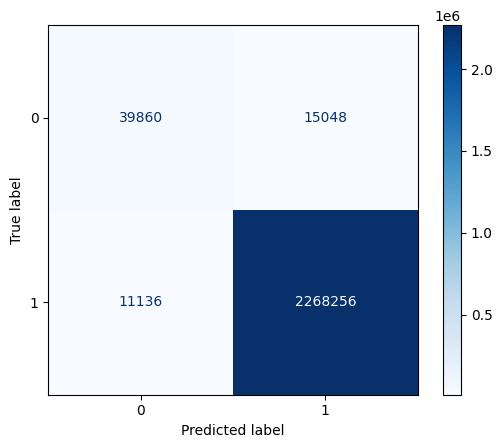

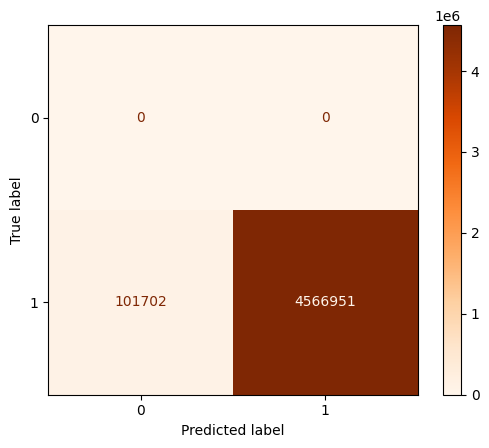

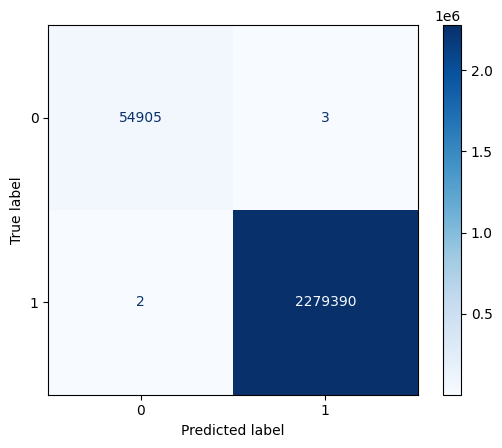

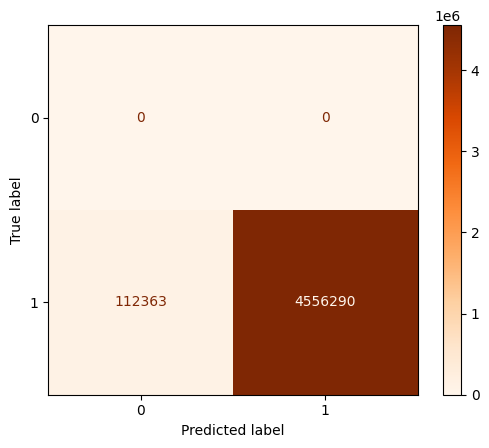

In [54]:
# %%time
# from sklearn.linear_model import LogisticRegression
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.neural_network import MLPClassifier
# import pickle
# from datetime import datetime

# from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

# ML_models = [
#     ("LogisticRegression", LogisticRegression(n_jobs=-1), f"logreg-{class_size}class-model.pkl"),
#     ("RandomForestClassifier", RandomForestClassifier(), f"rf-{class_size}class-model.pkl")
#     #("MLPClassifier", MLPClassifier(), f"mlp-{class_size}class-model.pkl")
# ]

# def train_and_evaluate(name, model, model_file, df):
#     print(datetime.now(), f" : Fit {name} model...")
#     model.fit(df[X_columns], df[y_column])
#     print(datetime.now(), f" : Fit {name} model complete...")
    
#     with open(model_file, "wb") as f:
#         pickle.dump(model, f)
    
#     y_test = []
#     preds = []
#     for test_set in tqdm(test_sets):
#         d_test = pd.read_csv(DATASET_DIRECTORY + test_set)
        
#         # DEBUG: Check what columns are in test data
#         print(f"Test file columns: {d_test.columns.tolist()}")
#         print(f"Test file shape: {d_test.shape}")
        
#         # Find the label column (might be named differently)
#         if 'label' in d_test.columns:
#             label_col = 'label'
#         elif 'target' in d_test.columns:
#             label_col = 'target'
#         elif 'class' in d_test.columns:
#             label_col = 'class'
#         else:
#             # Assume last column is the label
#             label_col = d_test.columns[-1]
            
#         print(f"Using label column: '{label_col}'")
#         print(f"Sample labels: {d_test[label_col].unique()[:5]}")
        
#         # PREPROCESS TEST DATA SAME AS TRAINING DATA
#         # Handle protocol_type encoding
#         d_test['protocol_type'] = le.transform(d_test['protocol_type'])
        
#         # Convert boolean columns to int
#         bool_columns = d_test.select_dtypes(include=['bool']).columns
#         d_test[bool_columns] = d_test[bool_columns].astype(int)
        
#         # Handle any remaining non-numeric columns
#         for col in X_columns:
#             if d_test[col].dtype == 'object':
#                 d_test[col] = le.transform(d_test[col].astype(str))
        
#         # Apply scaler to preprocessed data
#         d_test[X_columns] = scaler.transform(d_test[X_columns])
        
#         # Process labels - use the same string-to-binary mapping as training
#         if binary_classifier:
#             d_test[label_col] = d_test[label_col].apply(lambda x: 0 if 'Benign' in str(x) else 1)
        
#         y_test += list(d_test[label_col].values)
#         y_pred = list(model.predict(d_test[X_columns]))
#         preds += y_pred
        
#         break  # Only process first test file for debugging
        
#     print(f"##### {name} ({class_size} classes) #####")
#     print('accuracy_score: ', accuracy_score(preds, y_test))
#     print('recall_score: ', recall_score(preds, y_test, average='macro'))
#     print('precision_score: ', precision_score(preds, y_test, average='macro'))
#     print('f1_score: ', f1_score(preds, y_test, average='macro'))
#     print('\n')
# for name, model, model_file in ML_models:
#     train_and_evaluate(name, model, model_file, df)

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def train_and_evaluate(name, model, model_file, df):
    print(datetime.now(), f" : Fit {name} model...")
    model.fit(df[X_columns], df[y_column])
    print(datetime.now(), f" : Fit {name} model complete...")
    
    with open(model_file, "wb") as f:
        pickle.dump(model, f)
    
    # ----------- TRAIN EVALUATION -----------
    y_train = df[y_column]
    y_train_pred = model.predict(df[X_columns])
    
    print(f"\n##### {name} - TRAIN RESULTS #####")
    print("Accuracy :", accuracy_score(y_train, y_train_pred))
    print("Precision:", precision_score(y_train, y_train_pred, average="macro"))
    print("Recall   :", recall_score(y_train, y_train_pred, average="macro"))
    print("F1 Score :", f1_score(y_train, y_train_pred, average="macro"))
    
    cm_train = confusion_matrix(y_train, y_train_pred)
    ConfusionMatrixDisplay(confusion_matrix=cm_train).plot(cmap="Blues", values_format="d")
    
    # ----------- TEST EVALUATION -----------
    y_test, preds = [], []
    for test_set in tqdm(test_sets):
        d_test = pd.read_csv(DATASET_DIRECTORY + test_set)

        # pick correct label column
        if 'label' in d_test.columns:
            label_col = 'label'
        elif 'target' in d_test.columns:
            label_col = 'target'
        elif 'class' in d_test.columns:
            label_col = 'class'
        else:
            label_col = d_test.columns[-1]

        # preprocessing same as before
        d_test['protocol_type'] = le.transform(d_test['protocol_type'])
        bool_columns = d_test.select_dtypes(include=['bool']).columns
        d_test[bool_columns] = d_test[bool_columns].astype(int)
        for col in X_columns:
            if d_test[col].dtype == 'object':
                d_test[col] = le.transform(d_test[col].astype(str))
        d_test[X_columns] = scaler.transform(d_test[X_columns])
        
        if binary_classifier:
            d_test[label_col] = d_test[label_col].apply(lambda x: 0 if 'Benign' in str(x) else 1)
        
        y_test = d_test[label_col].values
        preds = model.predict(d_test[X_columns])
        break   # only first test set for now
    
    print(f"\n##### {name} - TEST RESULTS #####")
    print("Accuracy :", accuracy_score(y_test, preds))
    print("Precision:", precision_score(y_test, preds, average="macro"))
    print("Recall   :", recall_score(y_test, preds, average="macro"))
    print("F1 Score :", f1_score(y_test, preds, average="macro"))
    
    cm_test = confusion_matrix(y_test, preds)
    ConfusionMatrixDisplay(confusion_matrix=cm_test).plot(cmap="Oranges", values_format="d")

for name, model, model_file in ML_models:
    train_and_evaluate(name, model, model_file, df)



# Calculate Test Performance metrics

In [119]:
# y_test = []
# preds = {i:[] for i in range(len(ML_models))}
# for test_set in tqdm(test_sets):
#     d_test = pd.read_csv(DATASET_DIRECTORY + test_set)
    
#     # PREPROCESS TEST DATA FIRST (same as training data)
#     # Handle protocol_type encoding
#     d_test['protocol_type'] = le.transform(d_test['protocol_type'])
    
#     # Convert boolean columns to int
#     bool_columns = d_test.select_dtypes(include=['bool']).columns
#     d_test[bool_columns] = d_test[bool_columns].astype(int)
    
#     # Handle any remaining non-numeric columns
#     for col in X_columns:
#         if d_test[col].dtype == 'object':
#             d_test[col] = le.transform(d_test[col].astype(str))
    
#     # NOW apply scaler to preprocessed data
#     d_test[X_columns] = scaler.transform(d_test[X_columns])
    
#     # Handle labels - different test files have different label formats
#     if 'benign' in d_test.columns:
#         # Boolean format: True/False
#         d_test[y_column] = d_test['benign'].astype(int)
#     elif y_column in d_test.columns:
#         # Check if labels are strings (need binary mapping) or already numeric
#         if d_test[y_column].dtype == 'object':
#             # String labels - map to binary (same as training data)
#             d_test[y_column] = d_test[y_column].apply(lambda x: 0 if 'Benign' in str(x) else 1)
#         else:
#             # Already numeric
#             d_test[y_column] = d_test[y_column].astype(int)
#     else:
#         # Use last column as label
#         last_col = d_test.columns[-1]
#         if d_test[last_col].dtype == 'object':
#             d_test[y_column] = d_test[last_col].apply(lambda x: 0 if 'Benign' in str(x) else 1)
#         else:
#             d_test[y_column] = d_test[last_col].astype(int)
    
#     y_test += list(d_test[y_column].values)
    
#     # Get predictions from all models
#     for i, (name, model, model_file) in enumerate(ML_models):
#         y_pred = list(model.predict(d_test[X_columns]))
#         preds[i] = preds[i] + y_pred

100%|██████████| 3/3 [07:16<00:00, 145.38s/it]


In [ ]:
# from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

# # Get model names for display
# ML_names = [name for name, model, model_file in ML_models]

# print("Model Evaluation Results:")
# print("=" * 50)

# for k, v in preds.items():
#     y_pred = v
#     model_name = ML_names[k]
    
#     print(f"##### {model_name} ({class_size} classes) #####")
#     print(f'Accuracy Score: {accuracy_score(y_pred, y_test):.4f}')
#     print(f'Recall Score: {recall_score(y_pred, y_test, average="macro"):.4f}')
#     print(f'Precision Score: {precision_score(y_pred, y_test, average="macro"):.4f}')
#     print(f'F1 Score: {f1_score(y_pred, y_test, average="macro"):.4f}')
#     print()